In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 150
import seaborn as sns

from netam import framework, models

In [2]:
train_df, val_df = framework.load_shmoof_dataframes("/Users/matsen/data/shmoof_edges_11-Jan-2023_NoNode0_iqtree_K80+R_masked.csv") #, sample_count=5000)

In [3]:
kmer_length = 5
max_length = 410

train_dataset = framework.SHMoofDataset(train_df, kmer_length=kmer_length, max_length=max_length)
val_dataset = framework.SHMoofDataset(val_df, kmer_length=kmer_length, max_length=max_length)

print(f"we have {len(train_dataset)} training examples and {len(val_dataset)} validation examples")

we have 35830 training examples and 13186 validation examples


In [4]:
model = models.SHMoofModel(train_dataset)
burrito = framework.Burrito(train_dataset, val_dataset, model, batch_size=1024, learning_rate=0.1, l2_regularization_coeff=1e-6)
print("starting training...")
losses = burrito.train(epochs=100)
model.write_shmoof_output("_ignore/reshmoof")

starting training...
Epoch [1/100]	 Loss: 0.062847263	 Val Loss: 0.067294837
Epoch [2/100]	 Loss: 0.058914672	 Val Loss: 0.066932931
Epoch [3/100]	 Loss: 0.058793685	 Val Loss: 0.066905768
Epoch [4/100]	 Loss: 0.058754711	 Val Loss: 0.066861652
Epoch [5/100]	 Loss: 0.058719337	 Val Loss: 0.066829656
Epoch [6/100]	 Loss: 0.058712957	 Val Loss: 0.066801004
Epoch [7/100]	 Loss: 0.058685569	 Val Loss: 0.066732684
Epoch [8/100]	 Loss: 0.058668802	 Val Loss: 0.066761139
Epoch [9/100]	 Loss: 0.058655014	 Val Loss: 0.066724024
Epoch [10/100]	 Loss: 0.058643517	 Val Loss: 0.066709631
Epoch [11/100]	 Loss: 0.058620009	 Val Loss: 0.066732521
Epoch [12/100]	 Loss: 0.058622278	 Val Loss: 0.066651789
Epoch [13/100]	 Loss: 0.058612312	 Val Loss: 0.066682175
Epoch [14/100]	 Loss: 0.058592779	 Val Loss: 0.066658699
Epoch [15/100]	 Loss: 0.05857839	 Val Loss: 0.066678315
Epoch [16/100]	 Loss: 0.058575035	 Val Loss: 0.06665135
Epoch [17/100]	 Loss: 0.058576422	 Val Loss: 0.066585606
Epoch [18/100]	 Loss:

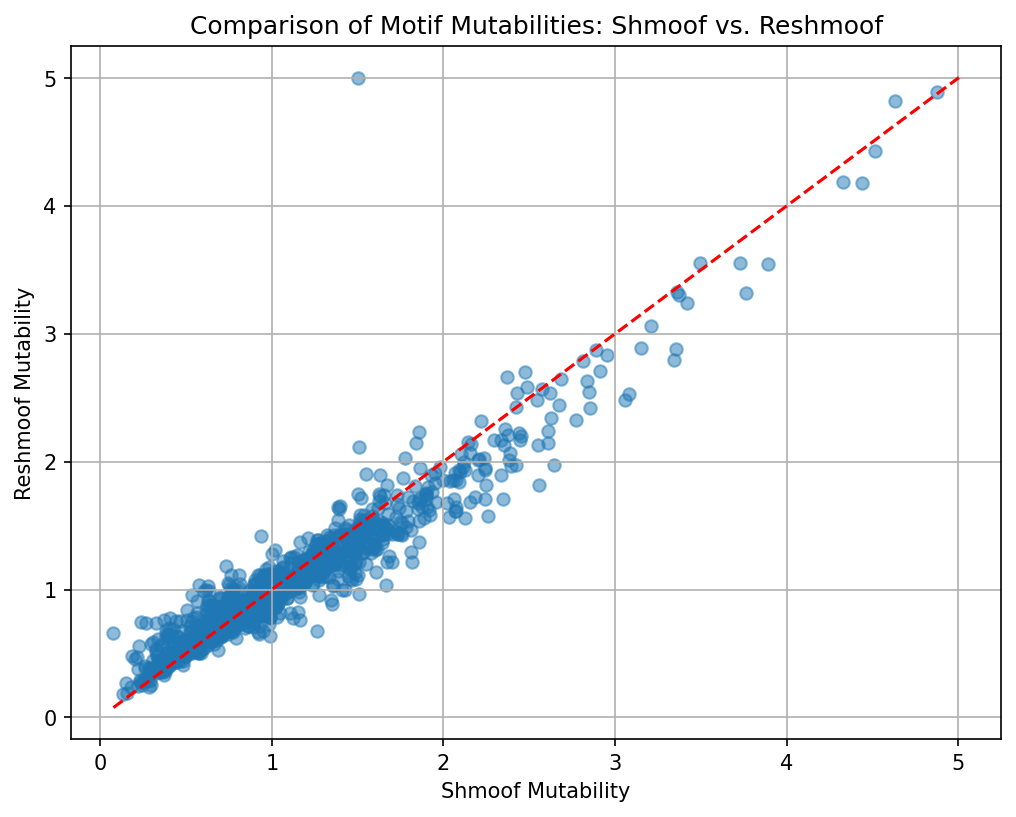

In [5]:
import pandas as pd
import matplotlib.pyplot as plt

# Load motif mutabilities
shmoof_motifs = pd.read_csv('_ignore/original_shmoof/mutabilities_context.tsv', sep='\t')
reshmoof_motifs = pd.read_csv('_ignore/reshmoof/motif_mutabilities.tsv', sep='\t')

# Merge dataframes
merged_motifs = pd.merge(shmoof_motifs, reshmoof_motifs, on='Motif', how='inner', suffixes=('_shmoof', '_reshmoof'))

# Scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(merged_motifs['Mutability_shmoof'], merged_motifs['Mutability_reshmoof'], alpha=0.5)

# Determine bounds for y=x line
min_bound = min(merged_motifs['Mutability_shmoof'].min(), merged_motifs['Mutability_reshmoof'].min())
max_bound = max(merged_motifs['Mutability_shmoof'].max(), merged_motifs['Mutability_reshmoof'].max())

# Add y=x line
plt.plot([min_bound, max_bound], [min_bound, max_bound], 'r--')

plt.xlabel('Shmoof Mutability')
plt.ylabel('Reshmoof Mutability')
plt.title('Comparison of Motif Mutabilities: Shmoof vs. Reshmoof')
plt.grid(True)
plt.show()

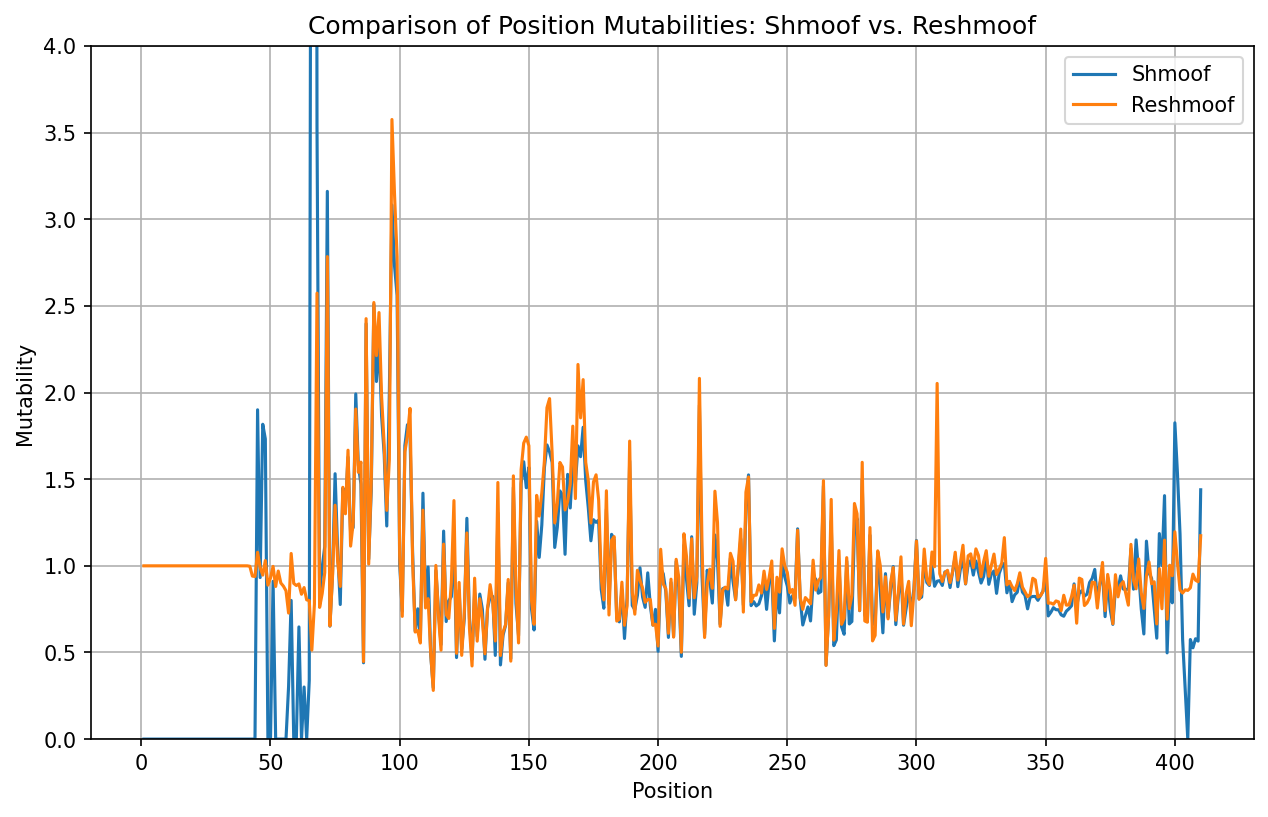

In [6]:
# Load position mutabilities
shmoof_positions = pd.read_csv('_ignore/original_shmoof/mutabilities_position.tsv', sep='\t')
reshmoof_positions = pd.read_csv('_ignore/reshmoof/site_mutabilities.tsv', sep='\t')

# Merge dataframes
merged_positions = pd.merge(shmoof_positions, reshmoof_positions, on='Position', suffixes=('_shmoof', '_reshmoof'))
merged_positions.sort_values(by='Position', inplace=True)

# Line plot
plt.figure(figsize=(10, 6))
plt.plot(merged_positions['Position'], merged_positions['Mutability_shmoof'], label='Shmoof')
plt.plot(merged_positions['Position'], merged_positions['Mutability_reshmoof'], label='Reshmoof')
plt.xlabel('Position')
plt.ylabel('Mutability')
plt.ylim(0, 4)

plt.title('Comparison of Position Mutabilities: Shmoof vs. Reshmoof')
plt.legend()
plt.grid(True)
plt.show()


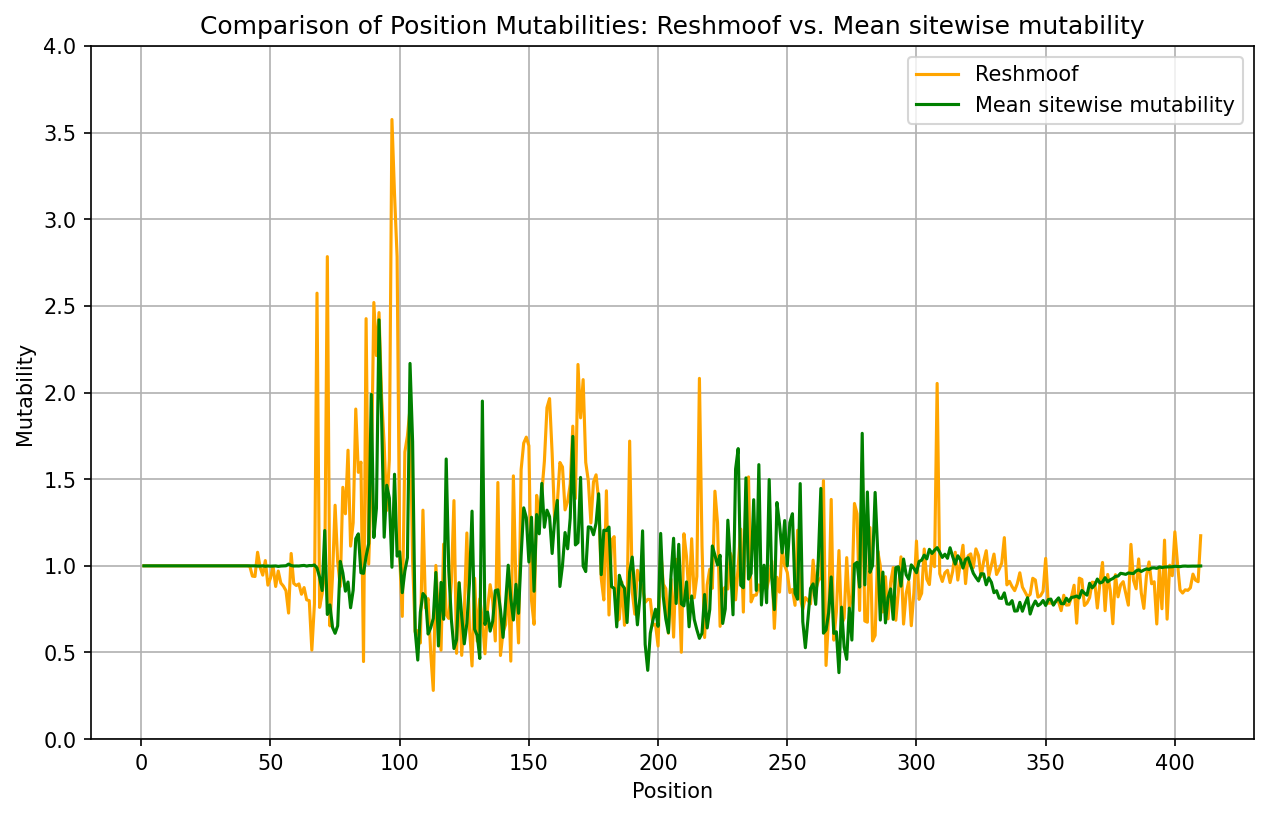

In [7]:
kmer_mutabilities = []

# turn reshmoof_motifs into a dict mapping "Motif" to "Mutability"
reshmoof_motifs_dict = dict(zip(reshmoof_motifs["Motif"], reshmoof_motifs["Mutability"]))

for parent in train_df["parent"]:
    kmer_mutability = np.ones(410)
    padded_parent = "NN" + parent + "NN"
    for i in range(min(410, len(padded_parent) - 5)):
        kmer_mutability[i] = reshmoof_motifs_dict.get(padded_parent[i:i+5], 1.0)
    kmer_mutabilities.append(kmer_mutability)

[kmer_mutability.shape for kmer_mutability in kmer_mutabilities]

mean_sitewise_mutability = np.stack(kmer_mutabilities).mean(axis=0)
mean_sitewise_mutability = pd.Series(mean_sitewise_mutability)

plt.figure(figsize=(10, 6))
# plt.plot(merged_positions['Position'], merged_positions['Mutability_shmoof'], label='Shmoof')
plt.plot(merged_positions['Position'], merged_positions['Mutability_reshmoof'], label='Reshmoof', color='orange')
plt.plot(merged_positions['Position'], mean_sitewise_mutability, label='Mean sitewise mutability', color='green')
# plt.xlim(75, 200)
plt.ylim(0, 4)
plt.xlabel('Position')
plt.ylabel('Mutability')
plt.title('Comparison of Position Mutabilities: Reshmoof vs. Mean sitewise mutability')
plt.legend()
plt.grid(True)
plt.show()

Training with regularization coefficient 0
Epoch [1/20]	 Loss: 0.062690129	 Val Loss: 0.066955227
Epoch [2/20]	 Loss: 0.058552012	 Val Loss: 0.0666062
Epoch [3/20]	 Loss: 0.058445681	 Val Loss: 0.066578256
Epoch [4/20]	 Loss: 0.058436915	 Val Loss: 0.066545529
Epoch [5/20]	 Loss: 0.058425217	 Val Loss: 0.066561554
Epoch [6/20]	 Loss: 0.058432286	 Val Loss: 0.066555381
Epoch [7/20]	 Loss: 0.058443837	 Val Loss: 0.06655271
Epoch [8/20]	 Loss: 0.058430624	 Val Loss: 0.066544126
Epoch [9/20]	 Loss: 0.058437878	 Val Loss: 0.066565669
Epoch 00009: reducing learning rate of group 0 to 2.0000e-02.
Epoch [10/20]	 Loss: 0.058318281	 Val Loss: 0.066420404
Epoch [11/20]	 Loss: 0.058266954	 Val Loss: 0.066403155
Epoch [12/20]	 Loss: 0.058263926	 Val Loss: 0.066412688
Epoch [13/20]	 Loss: 0.058262201	 Val Loss: 0.06641345
Epoch [14/20]	 Loss: 0.058261646	 Val Loss: 0.066408751
Epoch [15/20]	 Loss: 0.058261278	 Val Loss: 0.066406341
Epoch [16/20]	 Loss: 0.058262992	 Val Loss: 0.06641236
Epoch 00016: 

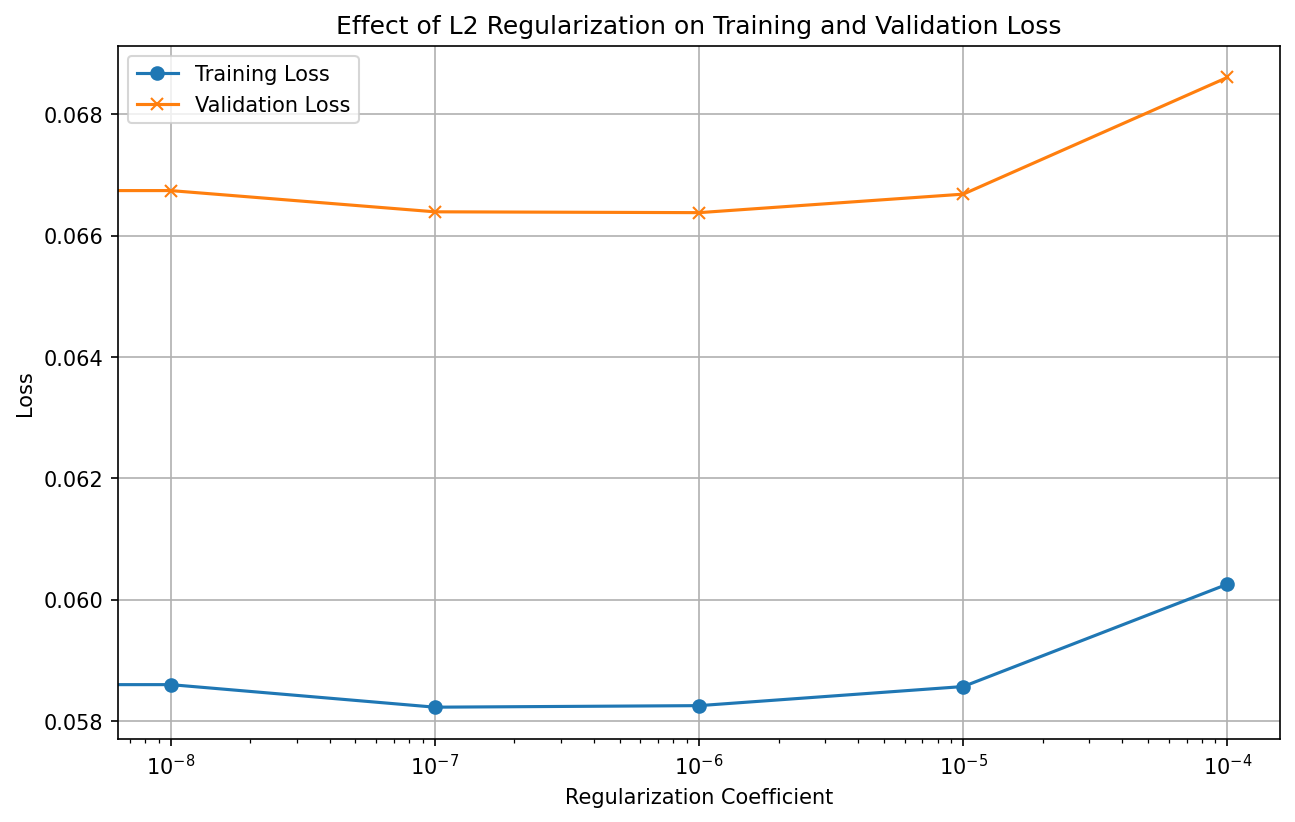

In [8]:
regularization_coeffs = [0, 1e-8, 1e-7, 1e-6, 1e-5, 1e-4]
results = []

for coeff in regularization_coeffs:
    print(f"Training with regularization coefficient {coeff}")
    model = models.SHMoofModel(train_dataset)
    burrito = framework.Burrito(train_dataset, val_dataset, model, batch_size=1024, learning_rate=0.1, l2_regularization_coeff=coeff)
    loss_history = burrito.train(epochs=20)
    final_training_loss = loss_history['training_losses'].iloc[-1]
    final_validation_loss = loss_history['validation_losses'].iloc[-1]

    results.append({
        'Regularization': coeff,
        'Final_Training_Loss': final_training_loss,
        'Final_Validation_Loss': final_validation_loss
    })

regularization_results_df = pd.DataFrame(results)
plt.figure(figsize=(10, 6))
plt.plot(regularization_results_df['Regularization'], regularization_results_df['Final_Training_Loss'], label='Training Loss', marker='o')
plt.plot(regularization_results_df['Regularization'], regularization_results_df['Final_Validation_Loss'], label='Validation Loss', marker='x')

plt.xscale('log')
plt.xlabel('Regularization Coefficient')
plt.ylabel('Loss')
plt.title('Effect of L2 Regularization on Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()